## TUTORIAL 05 - Discrete Empirical Interpolation Method for non-affine elliptic problems
**_Keywords: discrete empirical interpolation method_**

### 1. Introduction
In this Tutorial, we consider steady heat conduction in a two-dimensional square domain $\Omega = (-1, 1)^2$.
The boundary $\partial\Omega$ is kept at a reference temperature (say, zero). The conductivity coefficient is fixed to 1, while the heat source is characterized by the following expression
$$
g(\boldsymbol{x}; \boldsymbol{\mu}) = \exp\{ -2 (x_0-\mu_0)^2 - 2 (x_1 - \mu_1)^2\} \quad \forall \boldsymbol{x} = (x_0, x_1) \in \Omega.
$$

The parameter vector $\boldsymbol{\mu}$, given by 
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
affects the center of the Gaussian source $g(\boldsymbol{x}; \boldsymbol{\mu})$, which could be located at any point $\Omega$. Thus, the parameter domain is
$$
\mathbb{P}=[-1,1]^2.
$$

In order to obtain a faster evaluation (yet, provably accurate) of the problem we propose to use a certified reduced basis approximation for the problem. In order to preserve the affinity assumption (for the sake of performance) the discrete empirical interpolation method will be used on the forcing term $g(\boldsymbol{x}; \boldsymbol{\mu})$.

### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the temperature in the domain $\Omega$.

We will directly provide a weak formulation for this problem: for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \left\{ v \in H^1(\Omega(\mu_0)): v|_{\partial\Omega} = 0\right\}
$$
Note that, as in the previous tutorial, the function space is parameter dependent due to the shape variation. 
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u,v;\boldsymbol{\mu}) = \int_{\Omega} \nabla u \cdot \nabla v \ d\boldsymbol{x}$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v;\boldsymbol{\mu}) = \int_\Omega g(\boldsymbol{\mu}) v  \ d\boldsymbol{x}.$$

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(42)
np.random.seed(42)

## 3. Affine decomposition

The parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu})$ is trivially affine.
The discrete empirical interpolation method will be used on the forcing term $g(\boldsymbol{x}; \boldsymbol{\mu})$ to obtain an efficient (approximately affine) expansion of $f(\cdot; \boldsymbol{\mu})$.

In [2]:
@DEIM("online", basis_generation="Greedy")
@ExactParametrizedFunctions("offline")
class Gaussian(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=subdomains)
        self.f = ParametrizedExpression(
            self, "exp(- 2 * pow(x[0] - mu[0], 2) - 2 * pow(x[1] - mu[1], 2))", mu=(0., 0.),
            element=V.ufl_element())
        # note that we cannot use self.mu in the initialization of self.f, because self.mu has not been initialized yet

    # Return custom problem name
    def name(self):
        return "GaussianDEIM"

    # Return the alpha_lower bound.
    def get_stability_factor_lower_bound(self):
        return 1.

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        if term == "a":
            return (1.,)
        elif term == "f":
            return (1.,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = inner(grad(u), grad(v)) * dx
            return (a0,)
        elif term == "f":
            f = self.f
            f0 = f * v * dx
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 2),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 3)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/gaussian.xml")
subdomains = MeshFunction("size_t", mesh, "data/gaussian_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/gaussian_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the Gaussian class

In [5]:
problem = Gaussian(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(-1.0, 1.0), (-1.0, 1.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a reduced basis method

In [6]:
reduction_method = ReducedBasis(problem)
reduction_method.set_Nmax(20, DEIM=21)
reduction_method.set_tolerance(1e-4, DEIM=1e-8)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(100, DEIM=60)
reduced_problem = reduction_method.offline()

#### 4.5.2 Train PINN

Given a training set $X_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(n)})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(X_{PINN}; W) = \frac1n \sum_{i=1}^n \|A(\boldsymbol{\mu^{(i)}}) \operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)})\|_2^2$$

over $W$, where for a given $\boldsymbol{\mu}$, $A(\boldsymbol{\mu})$ is the assembled matrix corresponding to the pull back of $a_o$ and $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled vector corresponding to the pull back of $f_o$.

In [13]:
# build matrices for computing DEIM
selected_indices = sorted([idx[0] for idx in problem.DEIM_approximations['f'][0].interpolation_locations.get_dofs_list()])
U = np.array(problem._assemble_operator_DEIM('f')).T
P = []
for idx in selected_indices:
    new_column = np.zeros(U.shape[0])
    new_column[idx] = 1
    P.append(new_column)
P = np.array(P).T
PtUinv = np.linalg.inv(P.T @ U)

In [33]:
# Note that this is f, not c! Code in MLniCS probably needs to change...
selected_indices = sorted([idx[0] for idx in problem.DEIM_approximations['f'][0].interpolation_locations.get_dofs_list()])
dofs_locs = torch.tensor(V.tabulate_dof_coordinates()[selected_indices])
dx_test = torch.tensor(np.array(assemble(problem.v*dx))[selected_indices].reshape(-1, 1))

def DEIM_nonlinearity(mu):
    """
    mu: torch.tensor with shape (number of samples, number of parameters)
    """
    res = torch.exp(-2 * ((dofs_locs[:, 0].reshape(-1, 1) - mu[:, 0].view(1, -1))**2 + (dofs_locs[:, 1].reshape(-1, 1) - mu[:, 1].view(1, -1))**2))
    return torch.matmul(torch.tensor(PtUinv[:, :]), dx_test * res)

In [35]:
input_normalization_pinn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pinn = Normalization.StandardNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn, DEIM_func_f=DEIM_nonlinearity)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = None

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [36]:
pinn_trainer.train()

Operator 's' not implemented. Continuing without operator 's'...
Operator 's' not implemented. Continuing without operator 's'...
0 0.024847619214054907 	Loss(validation) = 0.02457328878753775
100 0.007984694054767127 	Loss(validation) = 0.006930649341527234
200 0.0023385924410409217 	Loss(validation) = 0.0022647036608073605
300 0.0011973609621856 	Loss(validation) = 0.0012828579957303264
400 0.0007032110661724653 	Loss(validation) = 0.0008271428266397775
500 0.00040036121064886463 	Loss(validation) = 0.0005403490593494696
600 0.00024931527671646973 	Loss(validation) = 0.0003855546013757814
700 0.00016947599779696003 	Loss(validation) = 0.0002939784918441147
800 0.00012392148884315693 	Loss(validation) = 0.00023597161419766977
900 9.591500857337998e-05 	Loss(validation) = 0.00019689726245515924
1000 7.705917978477602e-05 	Loss(validation) = 0.00016842757075332797
1100 6.335261088654789e-05 	Loss(validation) = 0.00014622377123027556
1200 5.293390578821229e-05 	Loss(validation) = 0.00012

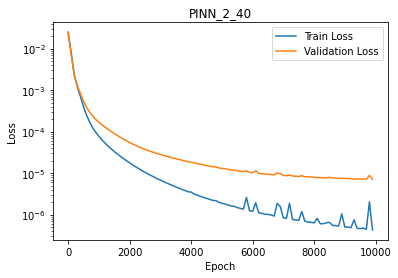

In [37]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $X_{PDNN} = ((\boldsymbol{\mu}^{(1)}, \operatorname{HF}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(n)}, \operatorname{HF}(\boldsymbol{\mu}^{(n)})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(X_{PDNN}; W) = \frac1n \sum_{i=1}^n \|\operatorname{N}_W(\boldsymbol{\mu}^{(i)}) - \tilde{\operatorname{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, $\tilde{\operatorname{HF}}(\boldsymbol{\mu})$ is the projection of $\operatorname{HF}(\boldsymbol{\mu})$ onto the reduced order solution space.

In [ ]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [ ]:
pdnn_trainer.train()

In [ ]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependnent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(X_{PINN}, X_{PDNN}; W) = L_{PINN}(X_{PINN}; W) + \omega L_{PDNN}(X_{PDNN}; W)$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [ ]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer,
    input_normalization_prnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [ ]:
prnn_trainer.train()

In [ ]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [38]:
reduction_method.initialize_testing_set(50, DEIM=60)
#reduction_method.error_analysis(filename="error_analysis")

False

#### 4.6.2 PINN Error Analysis

In [39]:
test_mu = torch.tensor(reduction_method.testing_set)

In [40]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_mu, input_normalization_pinn, output_normalization_pinn, relative=True
)

#################################### N = 20 ####################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.005285729638431327	0.005285779194127171	0.0022714087539158173
mean	0.01495138995019601	0.012089854314728374	0.007933275228882928
max	0.06621248468027635	0.040254669719136736	0.06251960932928137


In [ ]:
ErrorAnalysis.plot_solution_difference(
    pinn_net, (0.3, -1.0), input_normalization_pinn, output_normalization_pinn
)

#### 4.6.3 PDNN Error Analysis

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_mu, input_normalization_pdnn, output_normalization_pdnn
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    pdnn_net, (0.3, -1.0), input_normalization_pdnn, output_normalization_pdnn
)

#### 4.6.4 PRNN Error Analysis

In [ ]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_mu, input_normalization_prnn, output_normalization_prnn
)

In [ ]:
ErrorAnalysis.plot_solution_difference(
    prnn_net, (0.3, -1.0), input_normalization_prnn, output_normalization_prnn
)

#### 4.6.5 Neural Network Error Comparison

In [ ]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_mu, input_normalizations, output_normalizations, euclidean=False
)